In [1]:
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import os, psutil
import scipy 

In [2]:
class CIR:
    def __init__(self, tau, alpha, beta, seed=None):
        self.alpha = alpha
        self.beta = beta
        self.tau = tau
        self.rng = (
            default_rng(np.round(np.pi * 1e10).astype(int)) 
            if seed is None else default_rng(seed)
        )

    def sample_wiener_increments(self, num_realizations, num_timepoints, delta_t):
        return (
            self.rng.standard_normal((num_realizations, num_timepoints)) 
            * np.sqrt(delta_t)
        )

    def sample_ncx2(self, dof, lambda_):
        return scipy.stats.ncx2.rvs(dof, lambda_, random_state=self.rng)

    def __call__(self, x_0, num_realizations, num_timesteps, delta_t, method):
        # TODO: add validation logic for x_0 (should be 1D array)

        # Preallocate and set initial value.
        x = np.full((num_realizations, num_timesteps), fill_value=np.nan)
        x[:, 0] = x_0

        if method == 'euler_maruyama':
            dW = self.sample_wiener_increments(num_realizations, num_timesteps, delta_t)
            kappa = 1 / self.tau
            sigma = np.sqrt(2 / (self.tau * self.beta))
            theta = self.alpha / self.beta
            for i_timestep in range(num_timesteps-1):
                dX = (
                    kappa * (theta - x[:, i_timestep]) * delta_t
                    + sigma * np.sqrt(x[:, i_timestep]) * dW[:, i_timestep]
                )
                x[:, i_timestep+1] = x[:, i_timestep] + dX

            # Collect params to be returned.
            params = {
                'kappa' : kappa,
                'theta' : theta, 
                'sigma' : sigma
            }

        elif method == 'ncx2':
            # Precompute necessary parameters for sampling.
            kappa = 1 / self.tau
            sigma_sqr = 2 / (self.tau * self.beta)
            upsilon = np.exp(-kappa * delta_t)
            eta = (
                4 * kappa * upsilon 
                / (sigma_sqr * (1 - upsilon))
            )
            dof = 4 * kappa * (self.alpha / self.beta) / sigma_sqr

            # Iteratively update via sampling.
            for i_timestep in range(num_timesteps-1):
                x[:, i_timestep + 1] \
                    = self.sample_ncx2(dof, eta * x[:, i_timestep])
                
            # Collect params to be returned.
            params = {
                'kappa' : kappa,
                'sigma_sqr' : sigma_sqr,
                'eta' : eta,
                'dof' : dof
            }

        return x, params



In [ ]:
# Rate = alpha/beta.
params = {
    'cir' : {
        '1' : {
            'alpha' : 50,
            'beta' : 5,
            'tau' : 0.1
        },
        '2' : {
            'alpha' : 50,
            'beta' : 5,
            'tau' : 0.1
        },
        '12' : {
            'alpha' : 50,
            'beta' : 5,
            'tau' : 0.1
        },
    },
    'simulation' : {
        'num_realizations' : 2,
        'num_timesteps' : 50000,
        'delta_t' : 0.001, # 0.000125, 
        'method' : 'euler_maruyama'
    }
}
params['simulation']['x_0'] = np.zeros((params['simulation']['num_realizations'],))

# Prepare seeds. Can save entropy of seed_seq for reproducibility.
seed_seq = np.random.SeedSequence()
child_seeds = seed_seq.spawn(3)
for i_process, process in enumerate(params['cir'].keys()):
    params['cir'][process]['seed'] = child_seeds[i_process]

# Instantiate callable CIR objects.
cir = {key : CIR(**params['cir'][key]) for key in ['1', '2', '12']}


### Create rate functions r_1, r_2, and r['12']

[[0.         0.0125     0.02385438 0.0404495  0.05019438 0.06028174
  0.08545463 0.09721436 0.10825154 0.12217138 0.14220837 0.16646246
  0.15578256 0.18070564 0.1980805  0.21805614 0.2328646  0.25587983
  0.26226758 0.28213865 0.29820034 0.29890811 0.3099721  0.3283626
  0.33917991 0.33408465 0.35180667 0.36562073 0.36799807 0.37365569
  0.37521542 0.38223619 0.39106705 0.41641495 0.40402362 0.4376759
  0.46336068 0.46603484 0.50169004 0.54238979 0.55069134 0.55419148
  0.57927934 0.60360913 0.62816831 0.63661342 0.65478597 0.67305074
  0.69177769 0.72742168 0.70548295 0.72958013 0.74772747 0.7502235
  0.76846078 0.77502998 0.80684416 0.79665127 0.8255974  0.82851894
  0.85506714 0.85077451 0.86390596 0.85319248 0.85807729 0.86824708
  0.87606522 0.8820056  0.88954392 0.93968218 0.95056929 0.93017389
  0.93647473 0.94897028 1.00169413 1.00887033 1.0579741  1.04255335
  1.06446261 1.07305912 1.12061486 1.13923011 1.1539658  1.16741322
  1.2388984  1.2652014  1.26086651 1.2860908  1.307

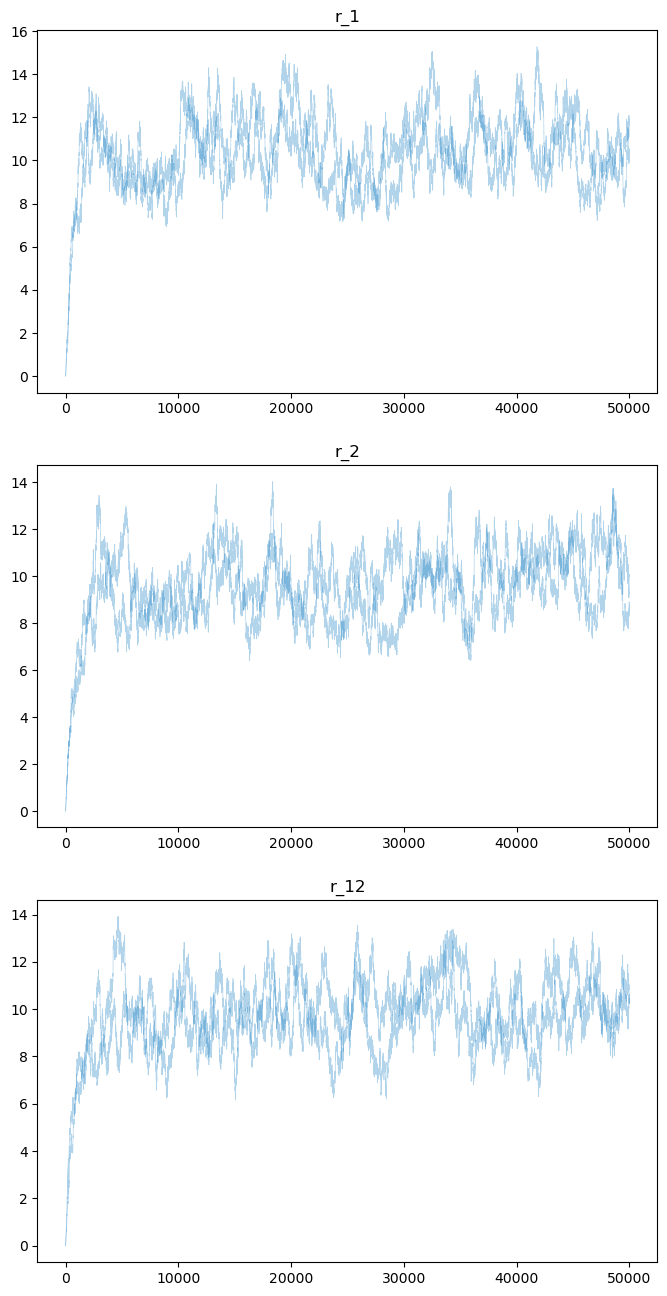

In [4]:
r = {key : cir[key](**params['simulation'])[0] for key in ['1', '2', '12']}

print(r['12'][:, :200])
fig_0, axs_0 = plt.subplots(3, 1, figsize=(8, 16))

for i_process, process in enumerate(r.keys()):
    for i_realization in range(r[process].shape[0]):
        axs_0[i_process].plot(r[process][i_realization, :], color=(0, 0.4470, 0.741), alpha=0.3, linewidth=0.5)
        axs_0[i_process].set_title(f"r_{process}")

### Simulate Poisson process

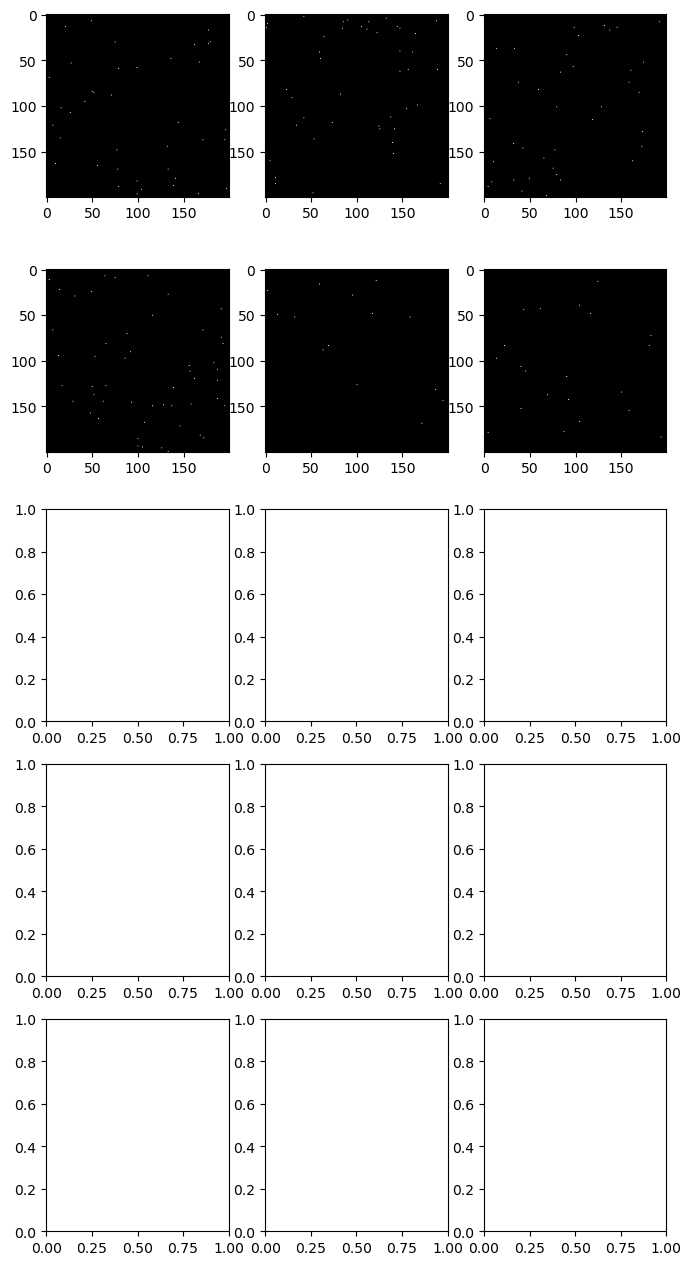

In [5]:
def generate_spikes(r, rng, num_inputs, num_timesteps, delta_t):
    """ 
    """
    if r.ndim != 1: 
        raise ValueError(f"`r` should be a 1d array, but got a {r.ndim}d array.")
    
    lambda_ = r * delta_t
    p = lambda_ * np.exp(-lambda_)
    u = rng.random((num_inputs, num_timesteps))
    spikes = (p[np.newaxis, :] > u).astype(int)

    # Convert to bool for space efficiency.
    return spikes.astype(np.uint8)

# Set parameters for generating spikes.
params['poisson_process'] = {
    'num_shared_inputs' : 500,
    'num_independent_inputs' : 500
}

# Prepare for plotting.
num_rows, num_cols = 5, 3
fig_1, axs_1 = plt.subplots(num_rows, num_cols, figsize=(8, 16))

# Precompute shapes of spike arrays for preallocation below.
spikes = dict()
spikes['1'] = np.full(
    (
        params['simulation']['num_realizations'],
        params['poisson_process']['num_independent_inputs'],
        params['simulation']['num_timesteps']
    ),
    np.nan
)
spikes['2'] = copy.deepcopy(spikes['1'])
spikes['12'] = np.full(
    (
        params['simulation']['num_realizations'],
        params['poisson_process']['num_shared_inputs'],
        params['simulation']['num_timesteps']
    ),
    np.nan
)

# Generate spiking input.
for i_realization in range(params['simulation']['num_realizations']):
    for process in ['1', '2', '12']:
        # Get number of inputs for current spikes matrix.
        num_inputs = (
            params['poisson_process']['num_shared_inputs'] if process == '12' 
            else params['poisson_process']['num_independent_inputs']
        )
        # Generate spikes.
        spikes[process][i_realization, :, :] = generate_spikes(
            r[process][i_realization, :],
            cir[process].rng,
            num_inputs,
            params['simulation']['num_timesteps'],
            params['simulation']['delta_t']
        )

        # Plot spikes.
        if i_realization <= num_rows-1:
            i_row = i_realization
            i_col = 0 if process == '1' else 1 if process == '2' else 2
            axs_1[i_row, i_col].imshow(spikes[process][i_realization, :200, 1000:1200], cmap='gray')
        # i_row, i_col = divmod(i_realization, 2)
        # if i_row <= num_rows-1 and i_col <= num_cols-1:
        #     axs_1[i_row, i_col].imshow(spikes['12'][i_realization, :100, 1000:1200], cmap='gray')
    

In [ ]:
process = psutil.Process(os.getpid())

def get_conductance_process(spikes, delta_t, h, membrane_tau):
    """ 
    Dimensions
    ----------
    N : Number of inputs.
    T : Number of timepoints.

    Parameters
    ----------
    spikes : np.ndarray (N, T)
        i_th, j_th element is 1 if synpase i receives input at timepoint j and 
        0 otherwise.
    h : np.ndarray (N,) or (1,)
        Vector of conductances over pre-synaptic inputs, or global scalar to be
        broadcast for all inputs.
    membrane_tau : float
        Membrane time constant.
    delta_t : flaot
        Size of discretization timestep.

    Returns
    -------
    conductances : np.ndarray (N, T)
        i_th row is conductance trace for i_th input synapse.
    """
    # Prepare filter.
    alpha = np.exp(-delta_t / membrane_tau)
    a = [1, -alpha]
    b = [1]

    # Apply filter and conductance for each input.
    conductances = scipy.signal.lfilter(b, a, spikes, axis=1)
    conductances = conductances * h[:, np.newaxis]

    return conductances

# Set parameters for computing conductance timeseries.
params['conductance_process'] = {
    'membrane_tau' : 0.02,
    'h' : np.array([0.001]), # synaptic conductance
}

# Can specify single weight for all input synapses, or one for each.
params['neuron'] = {
    '1' : {
        'w' : 0.5
    },
    '2' : {
        'w' : 0.5
    },
    '12' : {
        'w' : 0.5
    }
}

neuron_input_conductances = dict()
for neuron_idx in ['1', '2']:
    # Get conductance timeseries for each realization.  
    results = Parallel(n_jobs=-1)(
        delayed(get_conductance_process)(
            np.concatenate(
                (
                    spikes[neuron_idx][i_realization, :, :], 
                    spikes['12'][i_realization, :, :]
                ),
                axis=0
            ),
            params['simulation']['delta_t'], 
            **params['conductance_process']
        )
        for i_realization in range(params['simulation']['num_realizations'])
    )
    conductances = np.stack(results)

    # Apply weights for independent and shared inputs.
    conductances[:, :params['poisson_process']['num_independent_inputs'], :]  = (
        conductances[:, :params['poisson_process']['num_independent_inputs'], :] 
        * params['neuron'][neuron_idx]['w']
    )
    conductances[:, params['poisson_process']['num_independent_inputs']:, :] = (
        conductances[:, params['poisson_process']['num_independent_inputs']:, :] 
        * params['neuron']['12']['w']
    )
    
    neuron_input_conductances[neuron_idx] = conductances
 

[[1.58775469e-04 1.57786217e-04 1.56803128e-04 1.55826165e-04
  1.54855289e-04 1.53890461e-04 1.52931645e-04 1.51978803e-04
  1.51031898e-04 1.50090892e-04]
 [3.06821893e-03 3.04910236e-03 3.03010490e-03 3.01122580e-03
  2.99246433e-03 2.97381975e-03 2.95529134e-03 2.93687837e-03
  2.91858012e-03 2.90039588e-03]
 [1.15626230e-05 1.14905820e-05 1.14189898e-05 1.13478437e-05
  1.12771408e-05 1.12068785e-05 1.11370540e-05 1.10676644e-05
  1.09987072e-05 1.09301797e-05]
 [2.91738476e-05 2.89920796e-05 2.88114442e-05 2.86319342e-05
  2.84535427e-05 2.82762626e-05 2.81000871e-05 2.79250093e-05
  2.77510222e-05 2.75781192e-05]
 [1.46165632e-05 1.45254946e-05 1.44349933e-05 1.43450560e-05
  1.42556790e-05 1.41668588e-05 1.40785921e-05 1.39908753e-05
  1.39037050e-05 1.38170778e-05]
 [1.54215466e-06 1.53254625e-06 1.52299771e-06 1.51350866e-06
  1.50407873e-06 1.49470755e-06 1.48539476e-06 1.47613999e-06
  1.46694289e-06 1.45780309e-06]
 [9.35810518e-10 9.29979942e-10 9.24185693e-10 9.18427545e

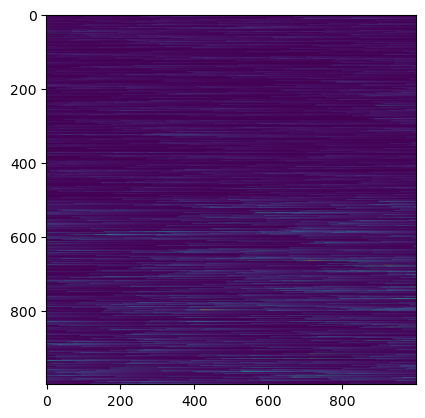

In [75]:
print(neuron_input_conductances['1'][0, -10:, -10:])
plt.imshow(neuron_input_conductances['1'][0, :, -1000:])
print(params['neuron']['12']['w'])

print(conductances[:, params['poisson_process']['num_independent_inputs']:, :].shape)

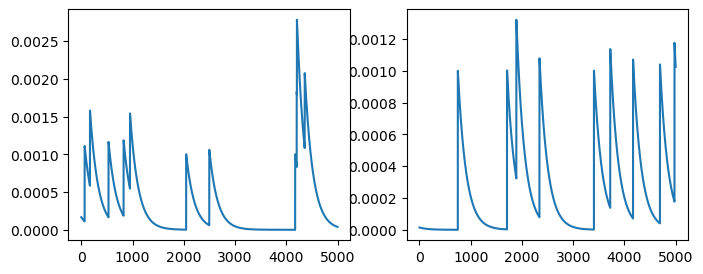

In [76]:
# Prepare for plotting.
i_input = 2
num_rows = min(10, -(-params['simulation']['num_realizations']//2))
fig_height = 3 * num_rows
fig_2a, axs_2a = plt.subplots(num_rows, 2, figsize=(8, fig_height), squeeze=False)

# Plot.
for i_realization in range(min(10, params['simulation']['num_realizations'])):
    i_row, i_col = divmod(i_realization, 2)
    axs_2a[i_row, i_col].plot(neuron_input_conductances['1'][i_realization, i_input, -5000:])

    # print(neuron_input_conductances['1'][i_realization, i_input, -200:])

(2, 1000, 50000)
(2, 50000)


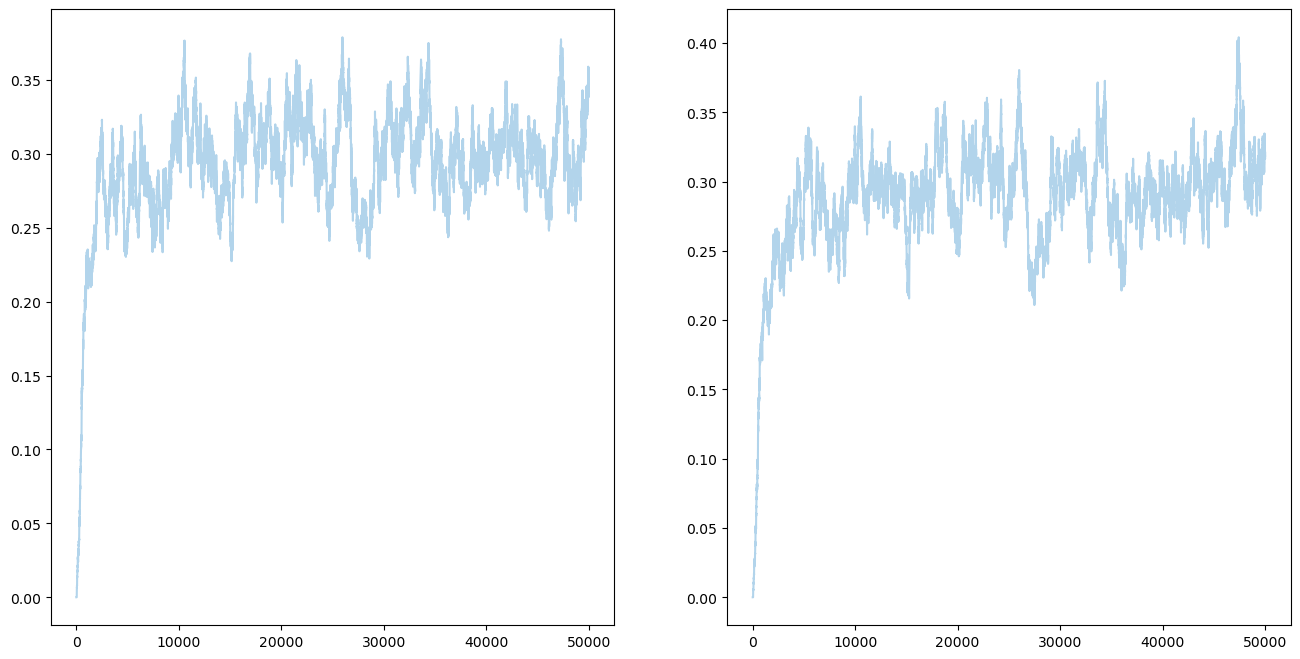

In [77]:
# For each realization, sum across inputs to get final conductance process.
neuron_soma_conductance = dict()
for neuron_idx in ['1', '2']:
    neuron_soma_conductance[neuron_idx] = np.sum(
        neuron_input_conductances[neuron_idx],
        axis=1
    )

fig_2b, axs_2b = plt.subplots(1, 2, figsize=(16, 8))
plot_all = False
num_realizations_to_plot = params['simulation']['num_realizations'] if plot_all else 1
for i_realization in range(num_realizations_to_plot):
    axs_2b[0].plot(neuron_soma_conductance['1'][i_realization, :], color=[0, 0.447, 0.741], alpha=0.3)
    axs_2b[1].plot(neuron_soma_conductance['2'][i_realization, :], color=[0, 0.447, 0.741], alpha=0.3)

print(neuron_input_conductances[neuron_idx].shape)
print(neuron_soma_conductance[neuron_idx].shape)



In [78]:
# Parameters for post-synaptic neurons' membrane voltage simulation (same for both).
t_span = (
    0, 
    params['simulation']['num_timesteps'] * params['simulation']['delta_t'],
)
params['postsynaptic_membrane'] = {
    'tau' : np.array([0.005]),
    'v_e' : np.array([70]),
    'v_0' : np.array([0]),
    't' : np.linspace(t_span[0], t_span[1], params['simulation']['num_timesteps'])
}

# Membrane voltage ODE.
def dv_dt(t, v, g, tau, v_e):
    return -(1 + g(t))/tau * v + g(t)/tau * v_e

neuron_voltage = dict()

for neuron_idx in ['1', '2']:
    solutions = []
    for i_realization in range(params['simulation']['num_realizations']):
        # Get total conductance process for current realization and interpolate.
        g = scipy.interpolate.interp1d(
            params['postsynaptic_membrane']['t'], 
            neuron_soma_conductance[neuron_idx][i_realization, :],
            kind='linear',
            fill_value='extrapolate'
        )

        sol = scipy.integrate.solve_ivp(
            dv_dt, 
            t_span, 
            params['postsynaptic_membrane']['v_0'], 
            t_eval=params['postsynaptic_membrane']['t'],
            args=(
                g, 
                params['postsynaptic_membrane']['tau'],
                params['postsynaptic_membrane']['v_e']
            ),
            method='RK45'
        )

        solutions.append(sol)

    neuron_voltage[neuron_idx] = solutions

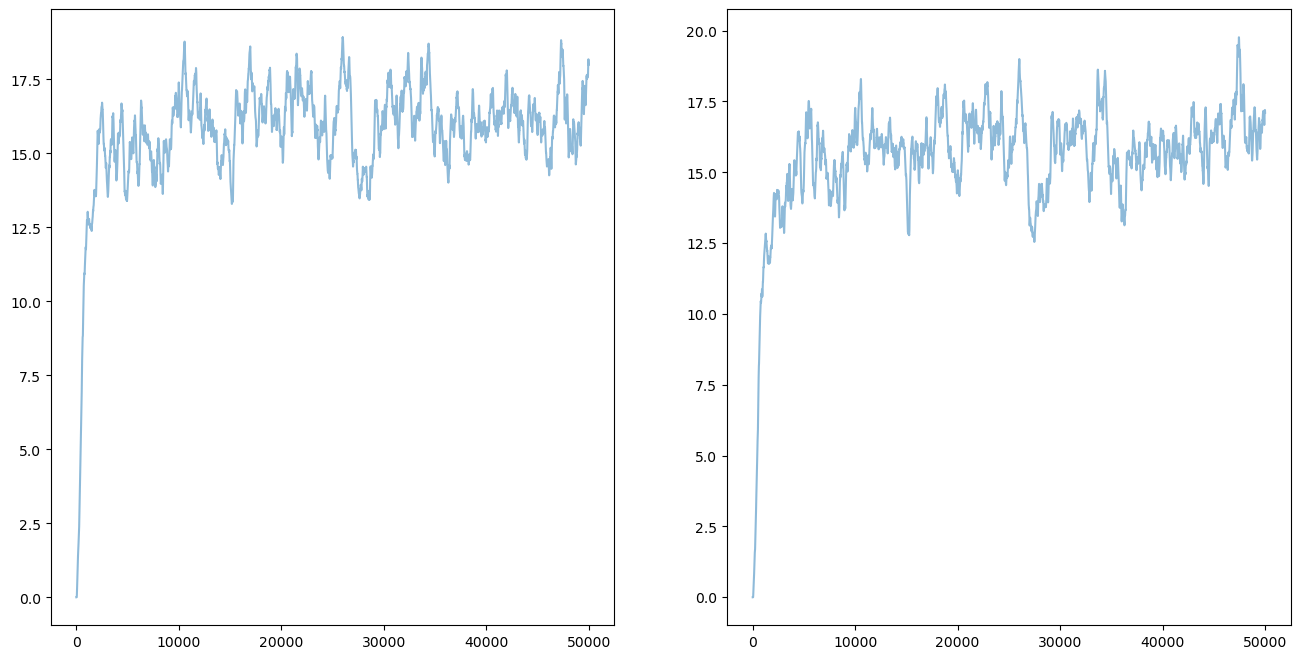

In [79]:
fig_3, axs_3 = plt.subplots(1, 2, figsize=(16, 8))
plot_all = False
num_realizations_to_plot = params['simulation']['num_realizations'] if plot_all else 1
for i_realization in range(num_realizations_to_plot):
    axs_3[0].plot(neuron_voltage['1'][i_realization].y[0], alpha=0.5)
    axs_3[1].plot(neuron_voltage['2'][i_realization].y[0], alpha=0.5)

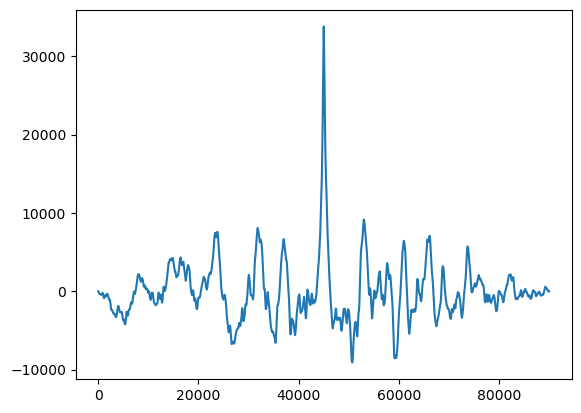

In [80]:
burn_in = 5000
stationary_length = params['simulation']['num_timesteps'] - burn_in
num_lags = 101 # Ideally odd

realization_idx = 0
v1 = neuron_voltage['1'][realization_idx].y[0][burn_in:]
v2 = neuron_voltage['2'][realization_idx].y[0][burn_in:]

v1 = (v1 - np.mean(v1)) / np.std(v1)
v2 = (v2 - np.mean(v2)) / np.std(v2)

r = scipy.signal.correlate(v1, v2, mode='full')
# mid_idx = (2 * len(v1) - 1) // 2
# lag_ind = np.concatenate((np.floor(np.linspace(0, mid_idx, -(-num_lags//2))), np.floor(np.linspace(mid_idx, 2*stationary_length-1, -(-num_lags//2))[1:])))

# r_subsampled = r[lag_ind]

# t1, t2 = np.meshgrid(np.linspace(0, stationary_length, num_lags), np.linspace(0, stationary_length, num_lags))

plt.plot(r)
